In [1]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
from jaxmarl.environments.coin_game.make_train import make_train
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Training

In [2]:
# Hiperparámetros
NUM_ENVS = 4
NUM_INNER_STEPS = 50
NUM_EPOCHS = 500
NUM_AGENTS = 2
SHOW_EVERY_N_EPOCHS = 10
SAVE_EVERY_N_EPOCHS = 50
LR = 1e-4
PAYOFF_MATRIX = [[1, 2, -3], [1, 2, -3]]
GRID_SIZE = 4
REWARD_COEF = [[1, 0], [1, 0]]

In [ ]:
training_type = 'AC_Minibatches'
save_dir = f'/data/samuel_lozano/coin_game/pruebas/{training_type}/Prisioner_dilemma/'

current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
path = os.path.join(save_dir, f"Training_{current_date}")

csv_file_path = os.path.join(save_dir, "training_stats.csv")

config = {
    "NUM_ENVS": NUM_ENVS,
    "NUM_INNER_STEPS": NUM_INNER_STEPS,
    "NUM_EPOCHS": NUM_EPOCHS,
    "NUM_AGENTS": NUM_AGENTS,
    "SHOW_EVERY_N_EPOCHS": SHOW_EVERY_N_EPOCHS,
    "SAVE_EVERY_N_EPOCHS": SAVE_EVERY_N_EPOCHS,
    "LR": LR,
    "MAX_GRAD_NORM": 0.5,
    "PAYOFF_MATRIX": PAYOFF_MATRIX,
    "GRID_SIZE": GRID_SIZE,
    "REWARD_COEF": REWARD_COEF,
    "SAVE_DIR": save_dir,
    "TRAINING_TYPE": training_type,
    "MINIBATCH_SIZE": 32,
    "MINIBATCH_EPOCHS": 4,
    "GAMMA": 0.995,
}

params = make_train(config)

# Analysis

In [2]:
# Directorios base
brigit = '/mnt/lustre/home/samuloza'
base_dirs = {
    "Prisioner_dilemma": f"{brigit}/data/samuel_lozano/coin_game/Prisioner_dilemma",
    "No_dilemma": f"{brigit}/data/samuel_lozano/coin_game/No_dilemma"
}

output_path = f"{brigit}/data/samuel_lozano/coin_game/training_results.csv"

In [3]:
all_dfs = []

# Patrón para capturar los coeficientes de recompensa
reward_pattern = re.compile(r"REWARD_COEF:\s*\[\[\s*([\d\.eE+-]+),\s*([\d\.eE+-]+)\],\s*\[\s*([\d\.eE+-]+),\s*([\d\.eE+-]+)\]\]")

In [4]:
for dilemma_name, base_dir in base_dirs.items():
    dilemma_flag = 1 if "Prisioner" in dilemma_name else 0
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        date_time_str = folder.replace("Training_", "")
        config_path = os.path.join(folder_path, "config.txt")
        csv_path = os.path.join(folder_path, "training_stats.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            continue

        with open(config_path, "r") as f:
            config_contents = f.read()
        match = reward_pattern.search(config_contents)
        if not match:
            continue

        alpha_1, beta_1, alpha_2, beta_2 = map(float, match.groups())

        grid_size_match = re.search(r"GRID_SIZE:\s*(\d+)", config_contents)
        grid_size = int(grid_size_match.group(1)) if grid_size_match else -1 

        lr_match = re.search(r"LR:\s*([0-9.eE+-]+)", config_contents)
        lr = float(lr_match.group(1)) 

        df = pd.read_csv(csv_path)

        df.insert(0, "timestamp", date_time_str)
        df.insert(1, "dilemma", dilemma_flag)
        df.insert(2, "alpha_1", alpha_1)
        df.insert(3, "beta_1", beta_1)
        df.insert(4, "alpha_2", alpha_2)
        df.insert(5, "beta_2", beta_2)
        df.insert(6, "grid_size", grid_size)
        df.insert(7, "lr", lr)

        all_dfs.append(df)

In [5]:
# Concatenar todos los resultados
final_df = pd.concat(all_dfs, ignore_index=True)
final_df.to_csv(output_path, index=False)

# Visualization

In [6]:
# Leer el CSV especificando los tipos de datos
dtype_dict = {
    "timestamp": str,
    "dilemma": int,
    "alpha_1": float,
    "beta_1": float,
    "alpha_2": float,
    "beta_2": float
}

# Cargar el CSV con conversión explícita al tipo numérico para el resto de columnas
brigit = '/mnt/lustre/home/samuloza'
df = pd.read_csv(output_path, dtype=dtype_dict, low_memory=False)
for col in df.columns[6:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear una columna identificadora de combinación de coeficientes
df = df.sort_values(by=["alpha_1", "alpha_2"], ascending=[False, False])
df["attitude_key"] = df.apply(lambda row: f"{row['alpha_1']}_{row['beta_1']}_{row['alpha_2']}_{row['beta_2']}", axis=1)
df["pure_reward_total"] = df["pure_reward_agent_0"] + df["pure_reward_agent_1"]

In [7]:
# Filtrar todas las combinaciones únicas
unique_attitudes = df["attitude_key"].unique()

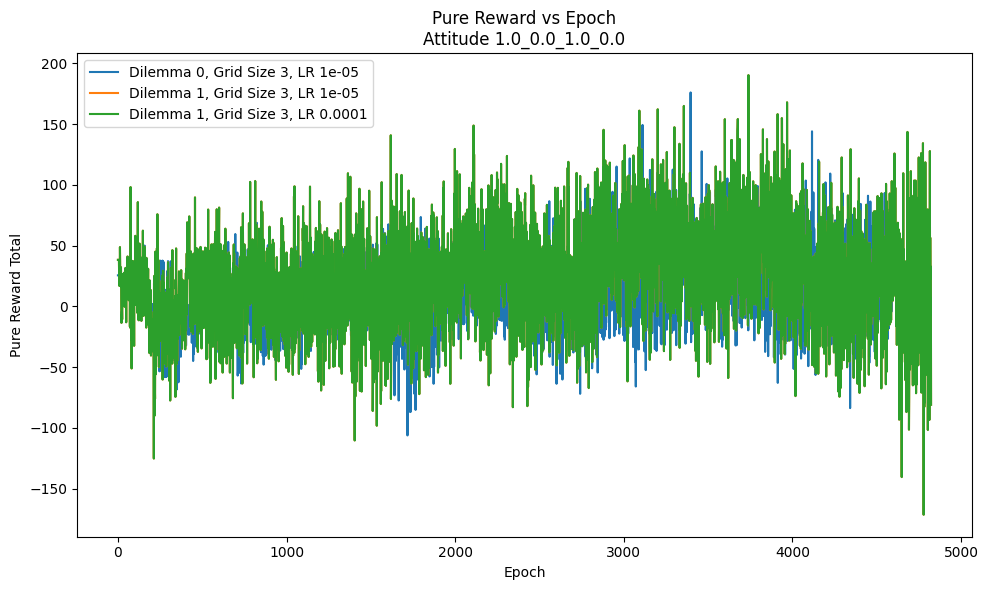

In [8]:
# Crear gráficas por combinación de coeficientes
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    # Crear la figura
    plt.figure(figsize=(10, 6))

    for dilemma_value in [0, 1]:
        filtered = subset[subset["dilemma"] == dilemma_value]

        for grid_size in filtered["grid_size"].unique():
            # Filtrar por grid_size
            grid_filtered = filtered[filtered["grid_size"] == grid_size]

            if grid_filtered.empty:
                continue

            # Filtrar por tasa de aprendizaje
            for lr in grid_filtered["lr"].unique():
                grid_lr_filtered = grid_filtered[grid_filtered["lr"] == lr]

                if grid_lr_filtered.empty:
                    continue

                # Agrupar por epoch y promediar la recompensa total
                grouped = grid_filtered.groupby("epoch")["pure_reward_total"].mean().reset_index()
                label = f"Dilemma {dilemma_value}, Grid Size {grid_size}, LR {lr}"
                plt.plot(grouped["epoch"], grouped["pure_reward_total"], label=label)

    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()

    # Mostrar la gráfica (puedes cambiar a savefig si quieres guardarlas)
    plt.show()

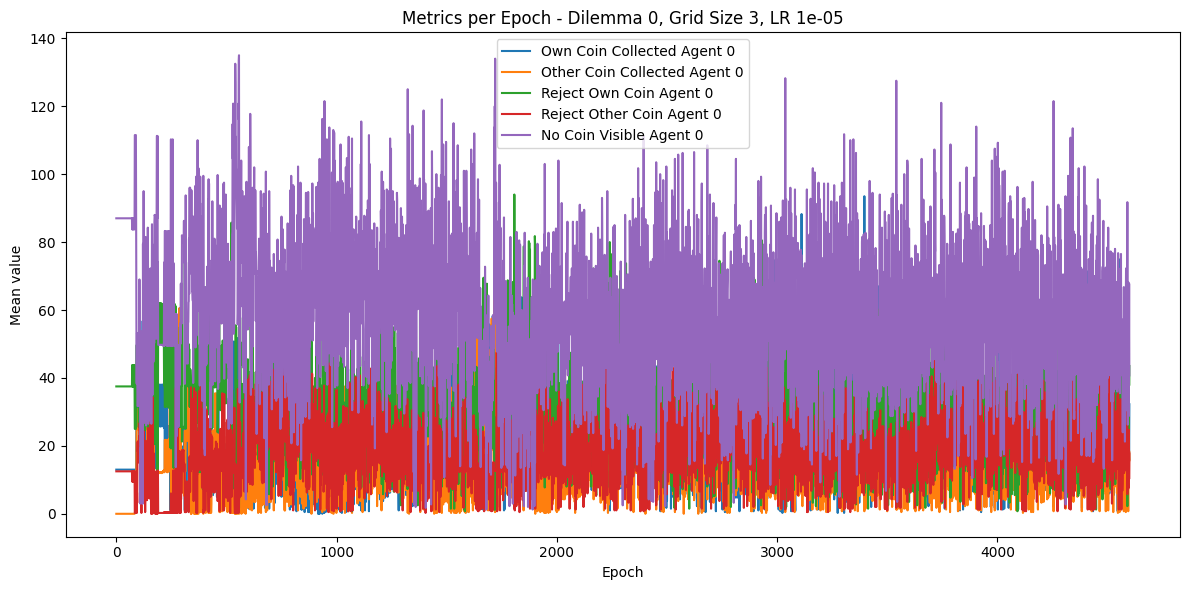

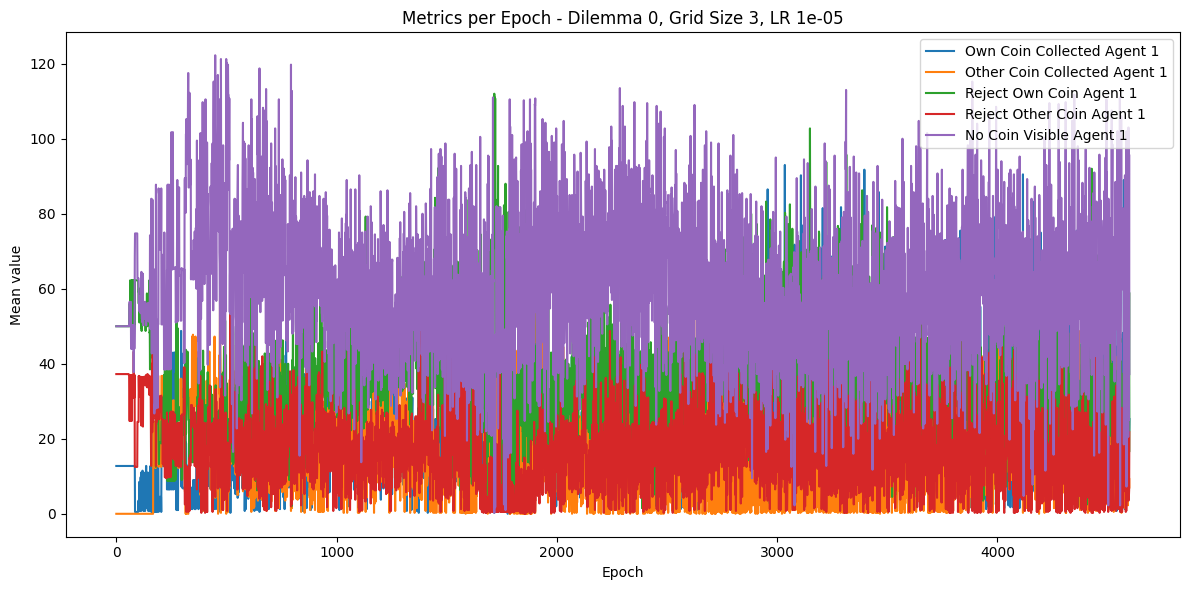

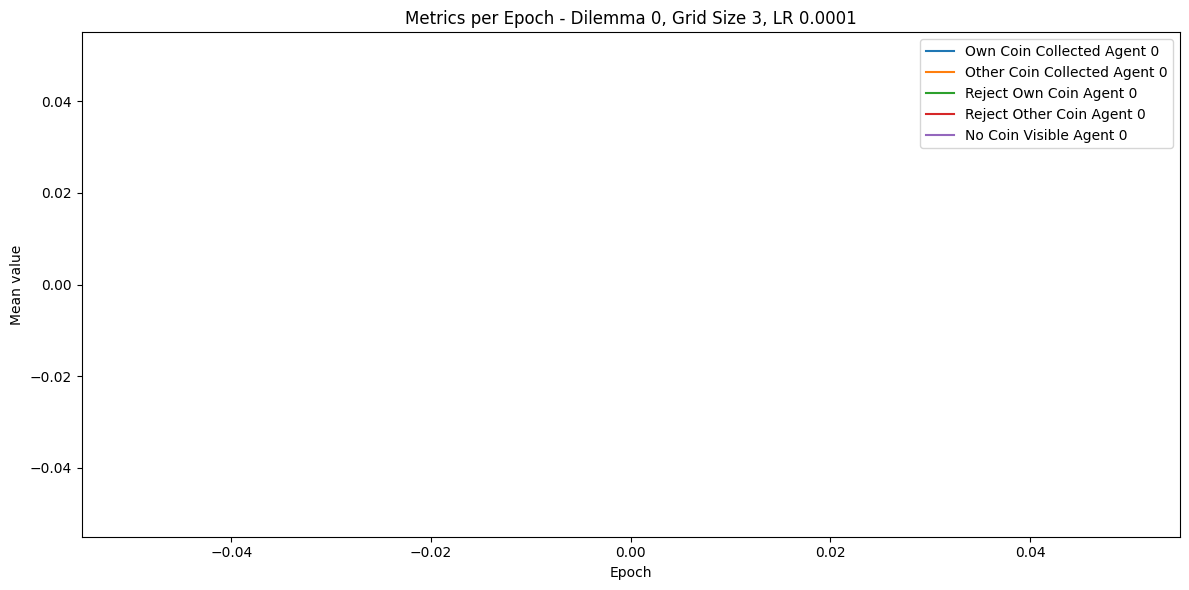

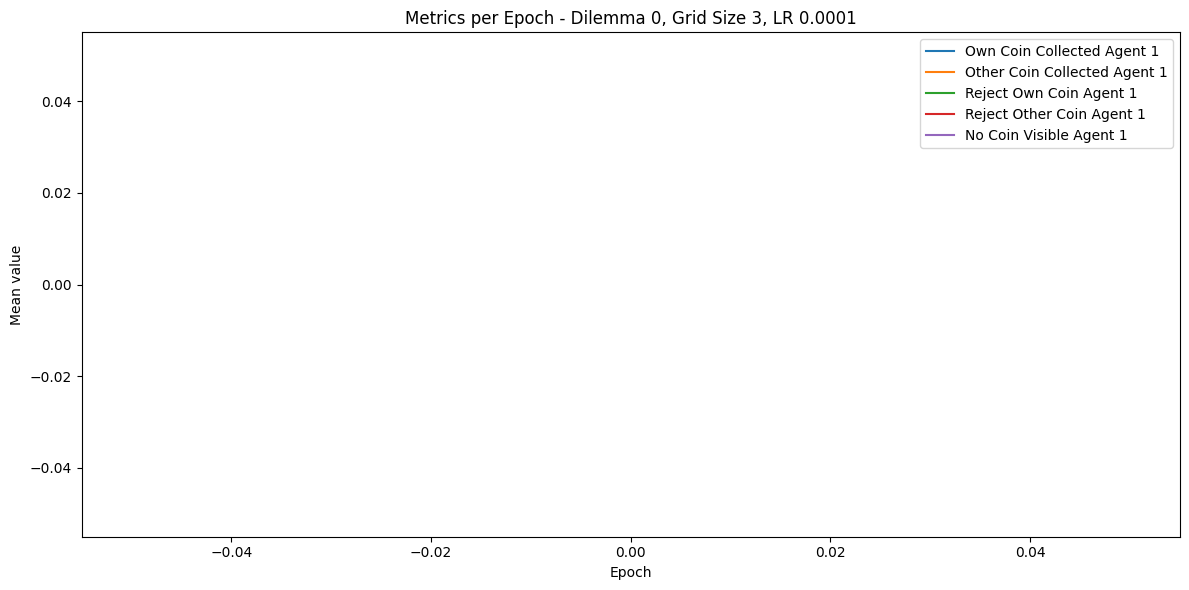

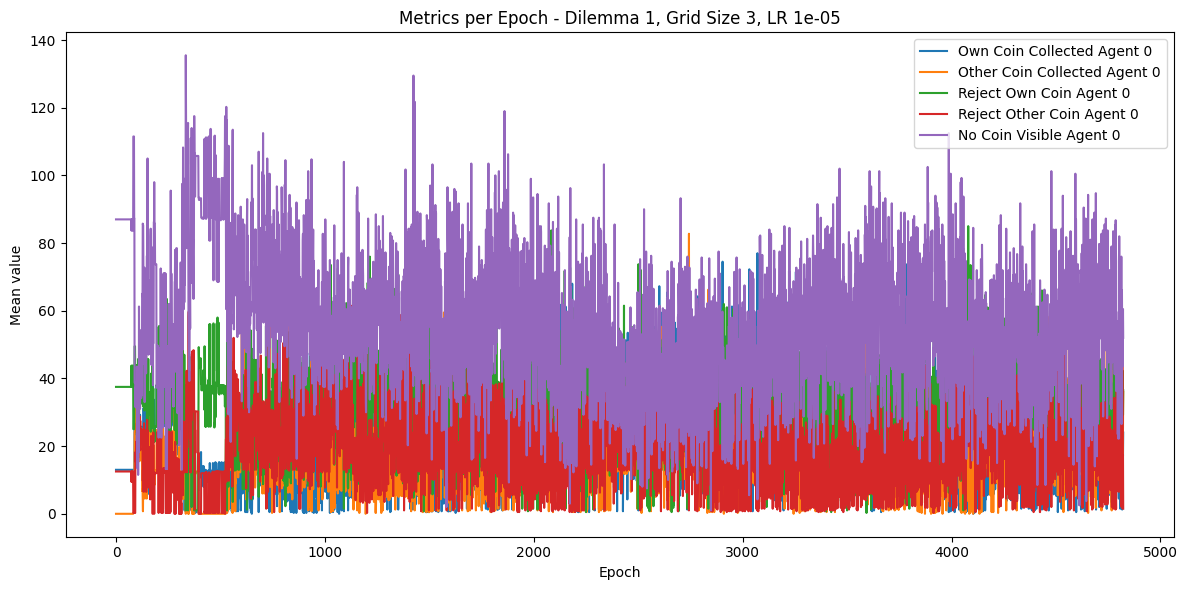

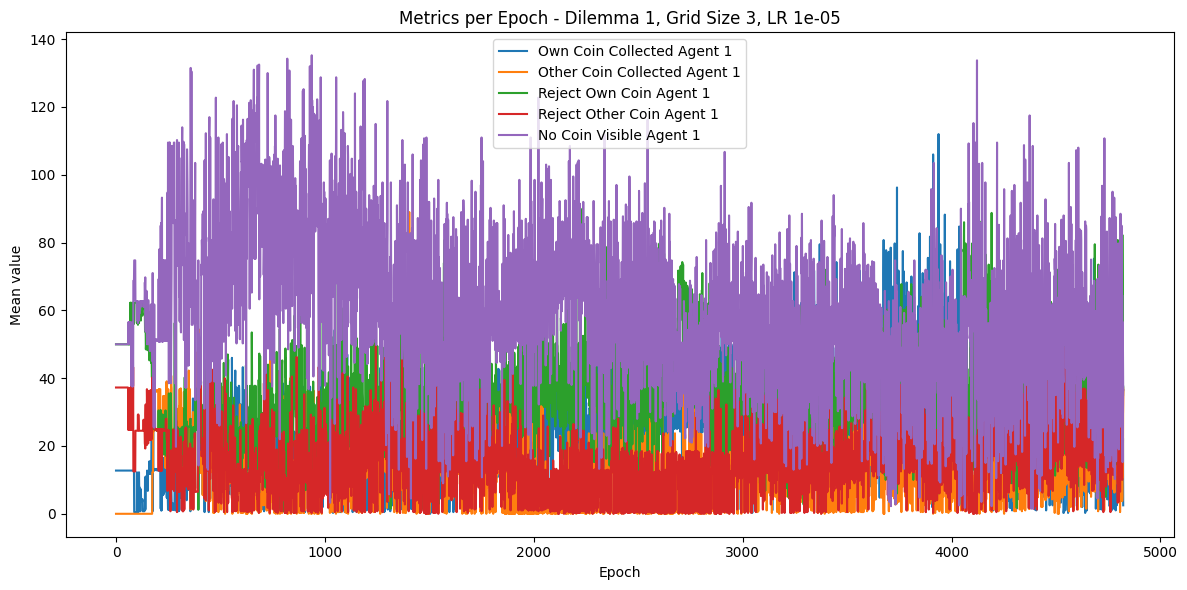

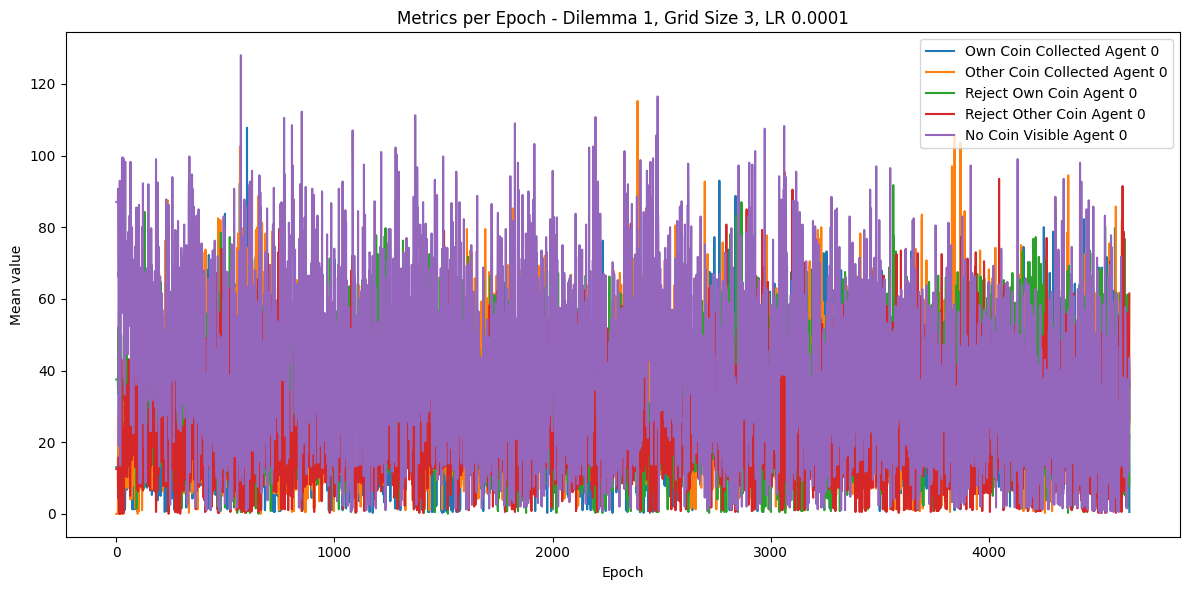

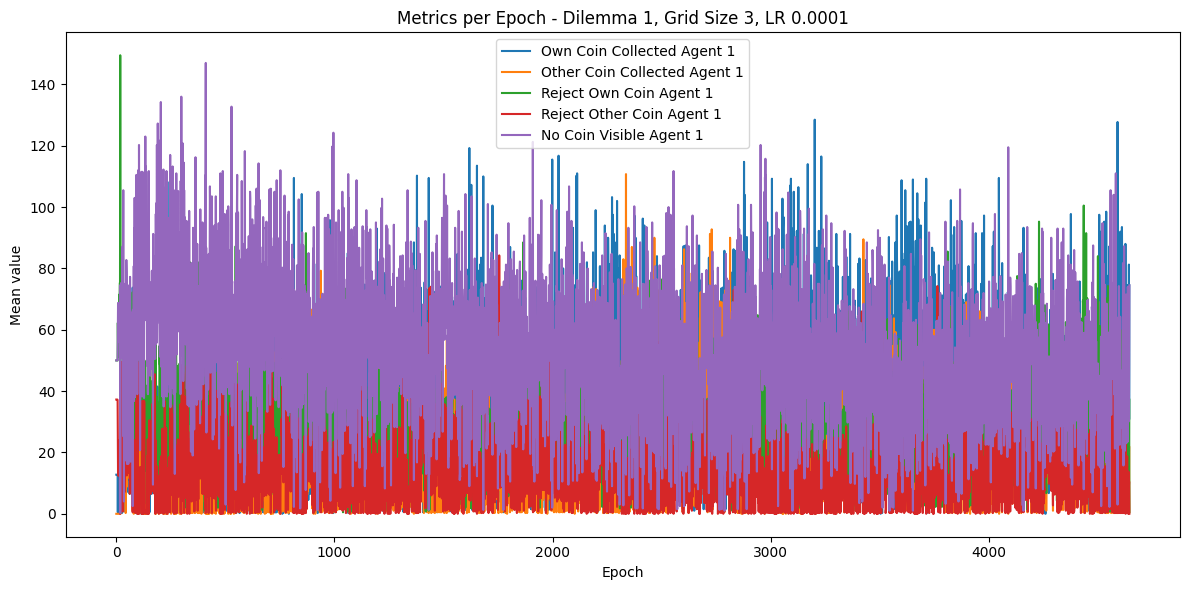

In [9]:
metrics_0 = [
    "own_coin_collected_agent_0",
    "other_coin_collected_agent_0",
    "reject_own_coin_agent_0",
    "reject_other_coin_agent_0",
    "no_coin_visible_agent_0"
]

metrics_1 = [
    "own_coin_collected_agent_1",
    "other_coin_collected_agent_1",
    "reject_own_coin_agent_1",
    "reject_other_coin_agent_1",
    "no_coin_visible_agent_1"
]

# Crear dos gráficas: una para dilemma=0 y otra para dilemma=1
for dilemma_value in [0, 1]:
    for grid_size in df["grid_size"].unique():
        for lr in df["lr"].unique():
            filtered_df = df[(df["dilemma"] == dilemma_value) & (df["grid_size"] == grid_size) & (df["lr"] == lr)]

            plt.figure(figsize=(12, 6))

            for metric in metrics_0:
                grouped = filtered_df.groupby(["epoch"])[metric].mean().reset_index()
                plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())

            plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, Grid Size {grid_size}, LR {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(12, 6))

            for metric in metrics_1:
                grouped = filtered_df.groupby(["epoch"])[metric].mean().reset_index()
                plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())

            plt.title(f"Metrics per Epoch - Dilemma {dilemma_value}, Grid Size {grid_size}, LR {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()
            plt.show()


## No averaging over environments

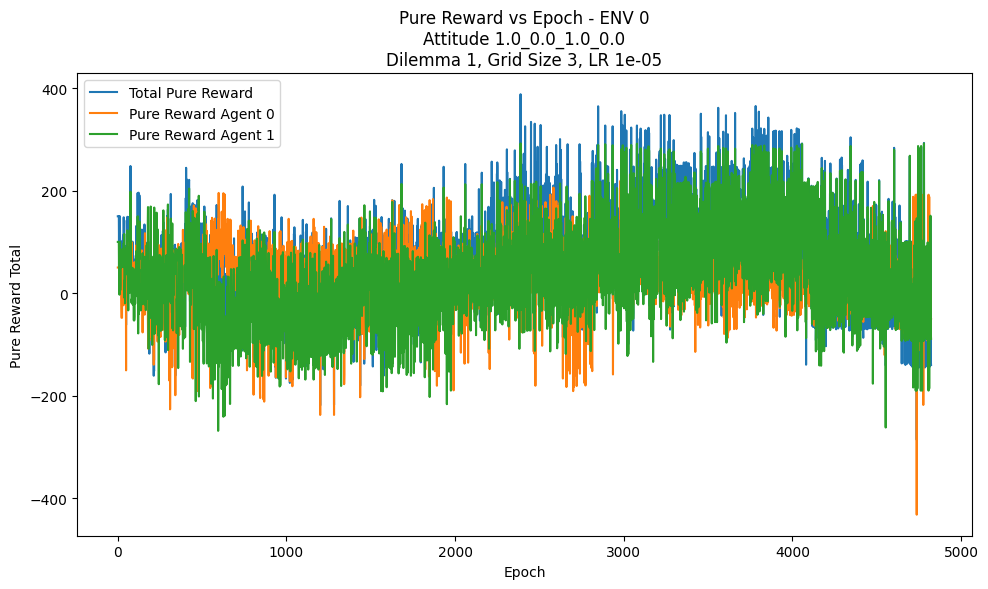

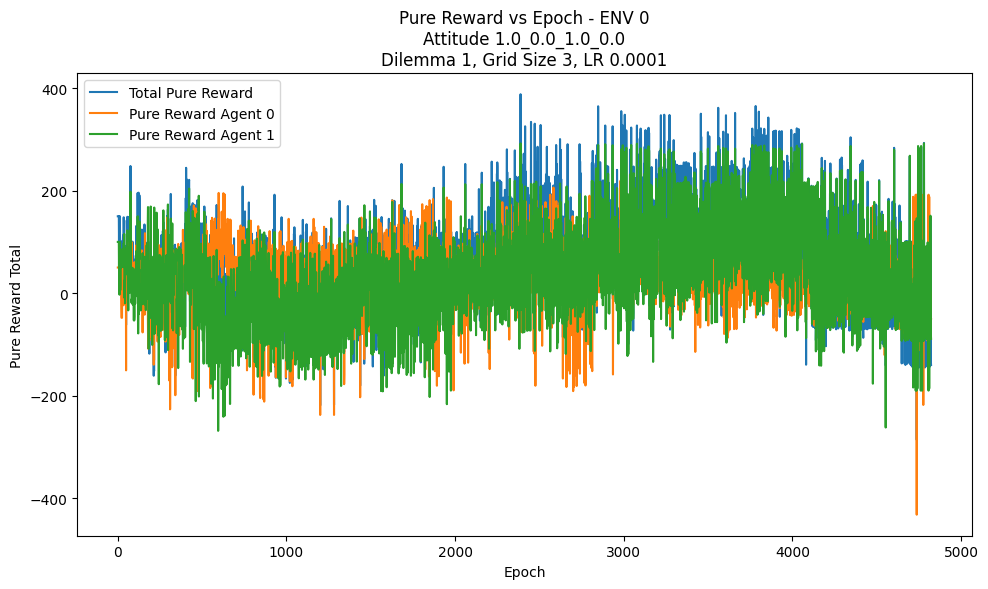

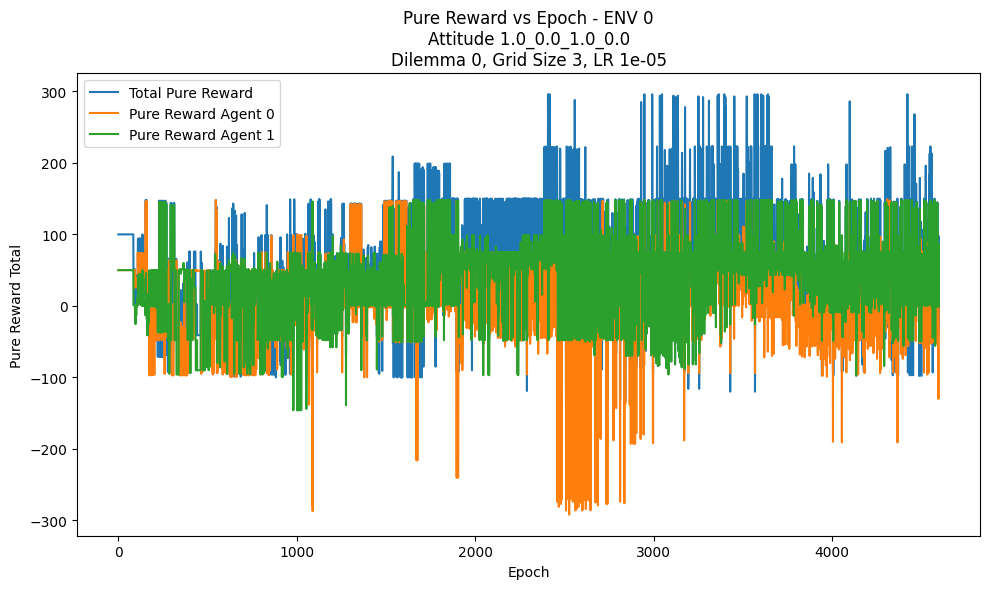

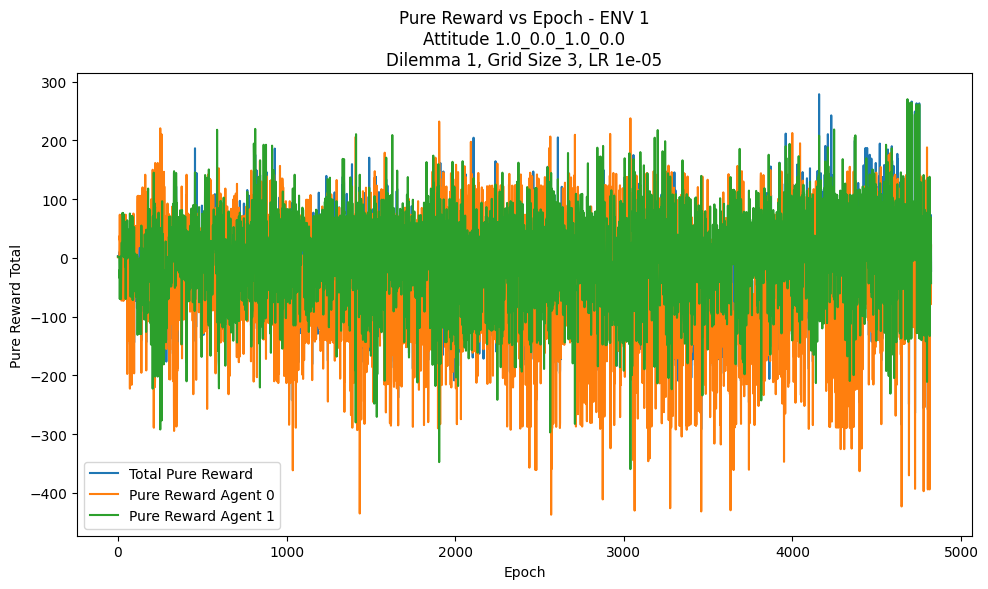

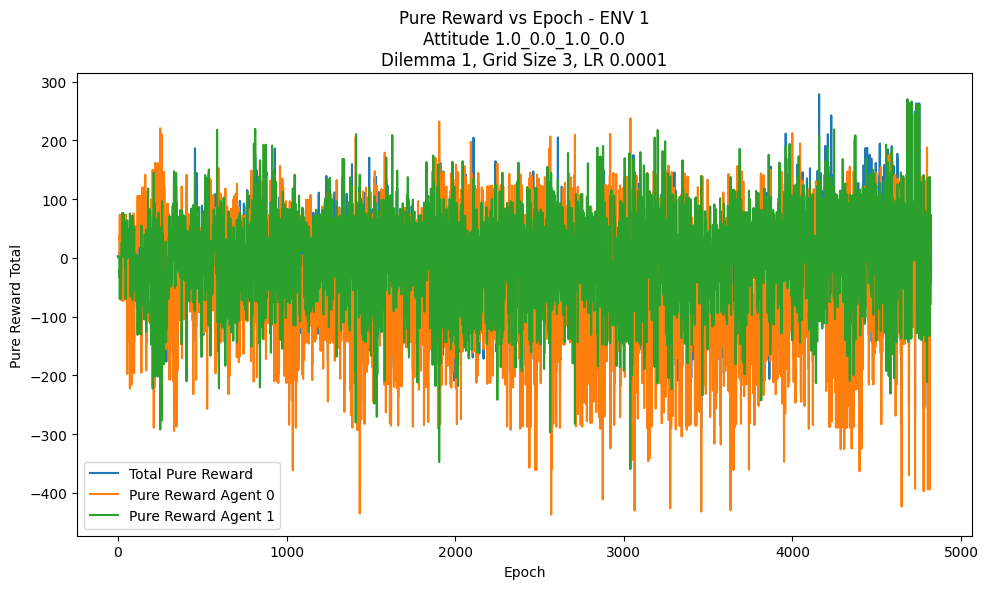

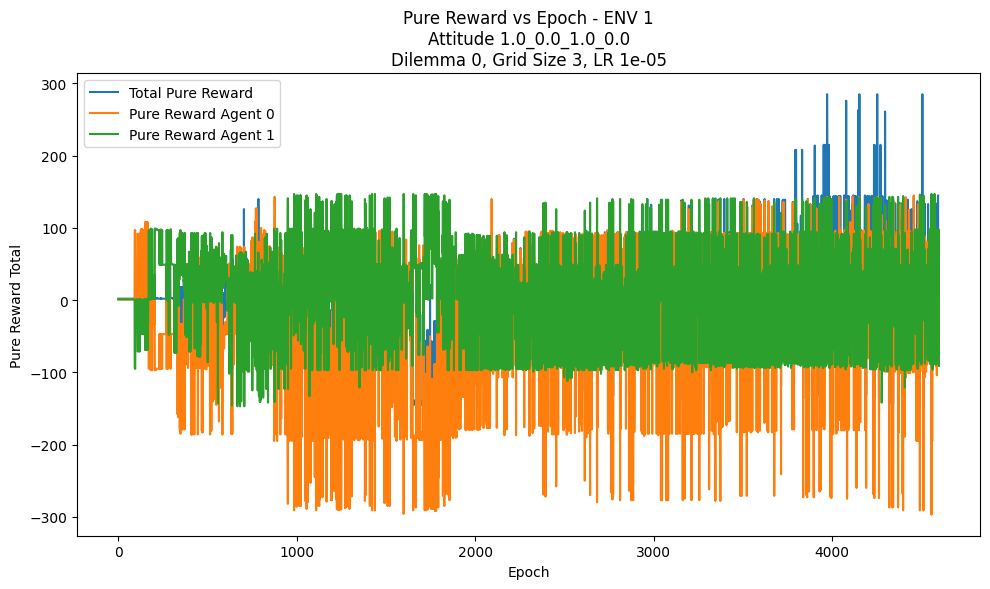

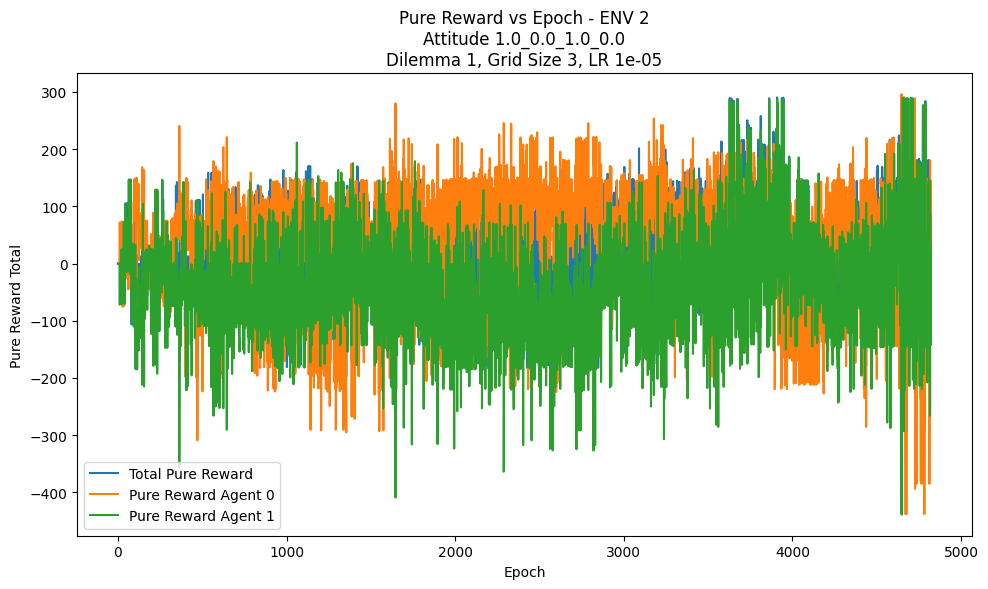

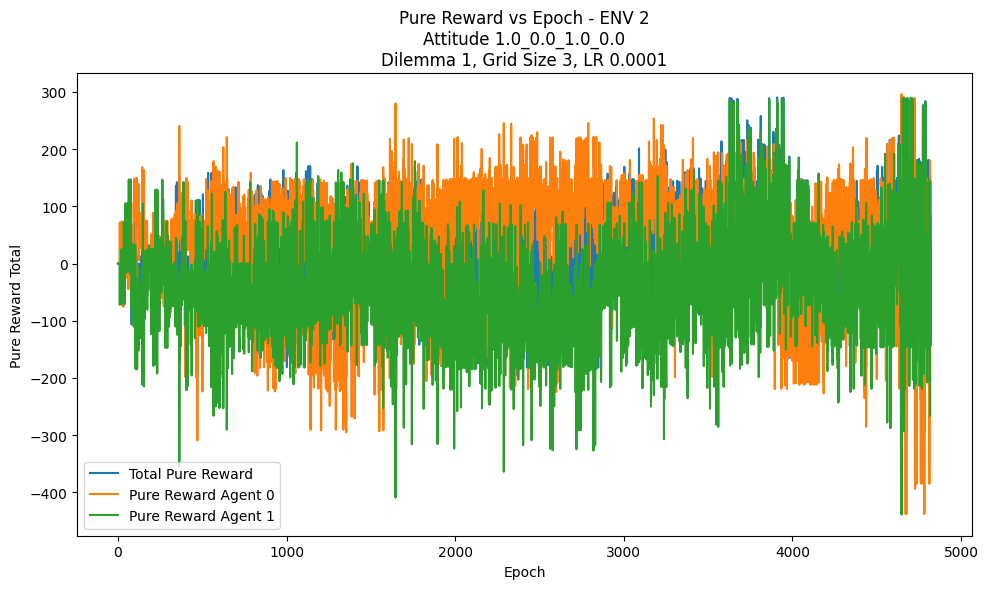

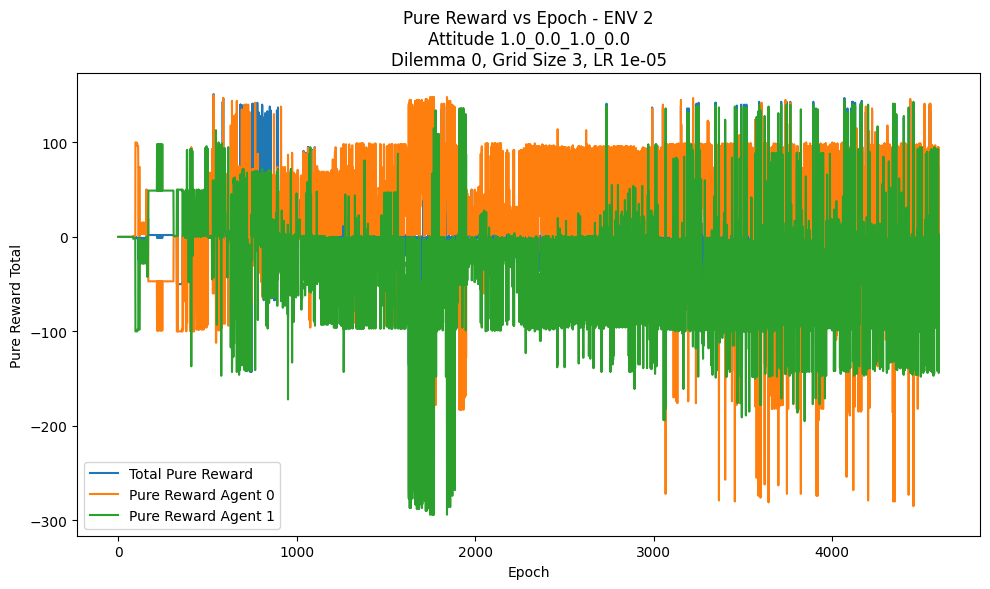

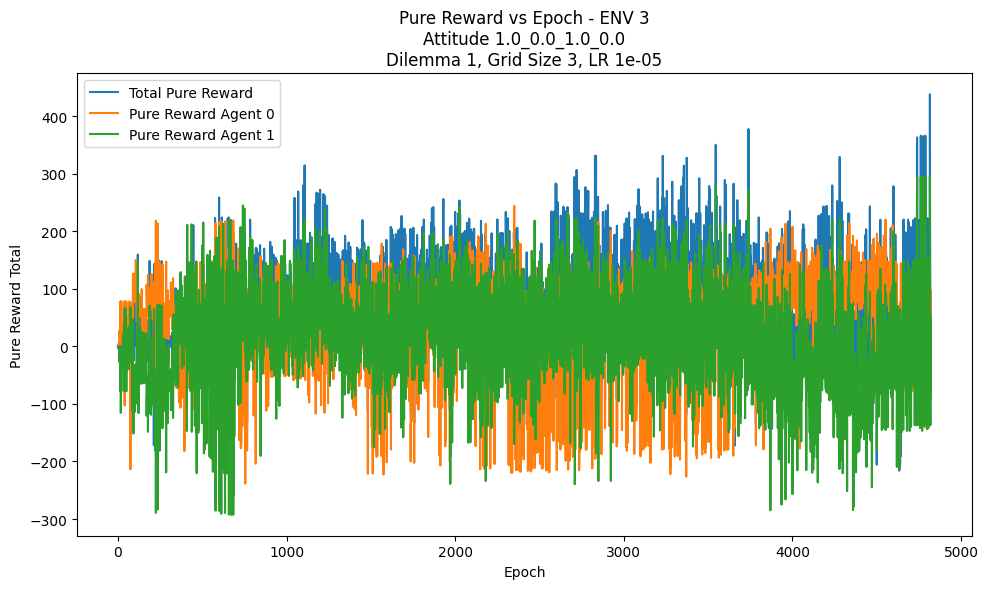

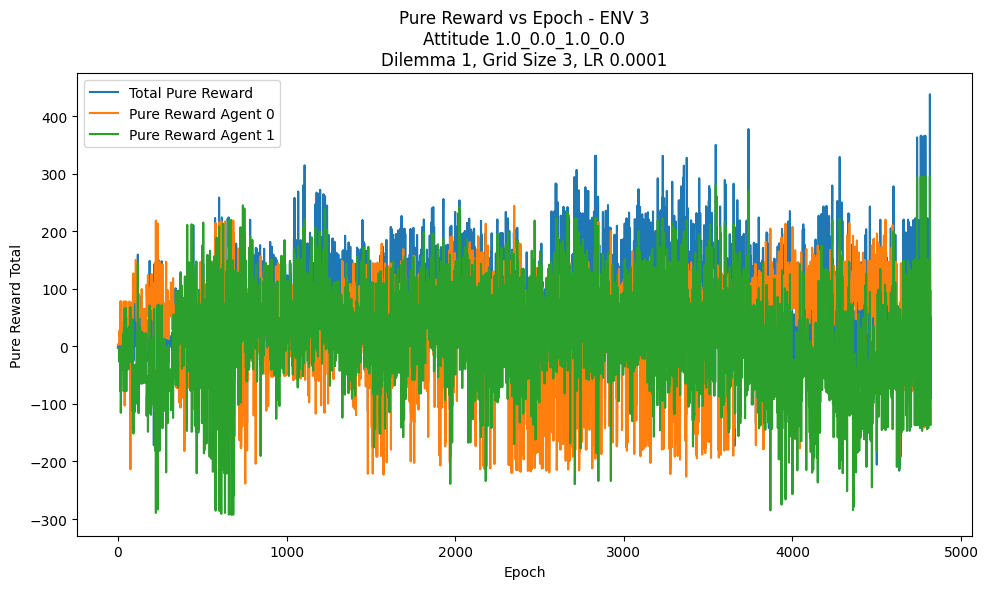

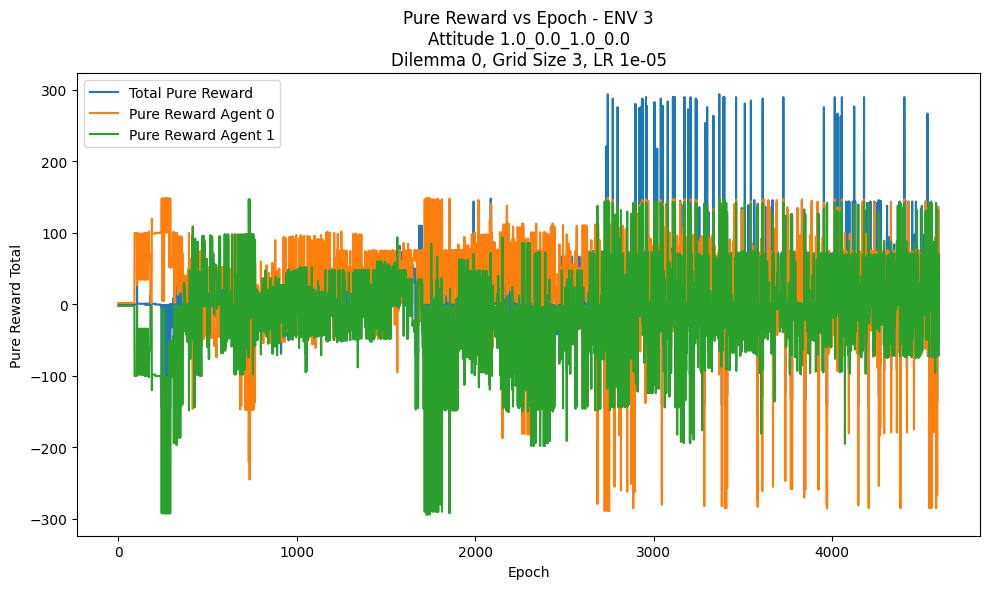

In [17]:
# Crear gráficas por combinación de coeficientes
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    for environment in subset["env"].unique():
        env_filtered = subset[subset["env"] == environment]

        for dilemma_value in env_filtered["dilemma"].unique():
            dilemma_filtered = env_filtered[env_filtered["dilemma"] == dilemma_value]
    
            for grid_size in dilemma_filtered["grid_size"].unique():
                # Filtrar por grid_size
                grid_filtered = dilemma_filtered[dilemma_filtered["grid_size"] == grid_size]
    
                if grid_filtered.empty:
                    continue
                
                # Filtrar por tasa de aprendizaje
                for lr in grid_filtered["lr"].unique():
                    grid_lr_filtered = grid_filtered[grid_filtered["lr"] == lr]
    
                    if grid_lr_filtered.empty:
                        continue

                    # Crear la figura
                    plt.figure(figsize=(10, 6))
                    
                    # Agrupar por epoch y promediar la recompensa total
                    grouped = grid_filtered.groupby("epoch")["pure_reward_total"].mean().reset_index()
                    grouped_0 = grid_filtered.groupby("epoch")["pure_reward_agent_0"].mean().reset_index()
                    grouped_1 = grid_filtered.groupby("epoch")["pure_reward_agent_1"].mean().reset_index()
                    plt.plot(grouped["epoch"], grouped["pure_reward_total"], label="Total Pure Reward")
                    plt.plot(grouped_0["epoch"], grouped_0["pure_reward_agent_0"], label="Pure Reward Agent 0")
                    plt.plot(grouped_1["epoch"], grouped_1["pure_reward_agent_1"], label="Pure Reward Agent 1")

                    # Añadir detalles
                    plt.title(f"Pure Reward vs Epoch - ENV {environment}\nAttitude {attitude}\nDilemma {dilemma_value}, Grid Size {grid_size}, LR {lr}")
                    plt.xlabel("Epoch")
                    #plt.xlim([0,100])
                    plt.ylabel("Pure Reward Total")
                    plt.legend()
                    plt.tight_layout()

                    # Mostrar la gráfica (puedes cambiar a savefig si quieres guardarlas)
                    plt.show()